In [16]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
import jax.experimental.optimizers as optimizers
import jax.random as jr
import jax.numpy as np
from jax import jit, value_and_grad
from tqdm.auto import trange
import matplotlib.pyplot as plt

from ssm.models.hmm.gaussian_hmm import make_gaussian_hmm
from ssm.inference.core import hmm_log_normalizer, hmm_expected_states
from ssm.plots import gradient_cmap
from ssm.utils import find_permutation

import seaborn as sns
sns.set_style("white")
sns.set_context("talk")

color_names = [
    "windows blue",
    "red",
    "amber",
    "faded green",
    "dusty purple",
    "orange"
    ]

colors = sns.xkcd_palette(color_names)
cmap = gradient_cmap(colors)

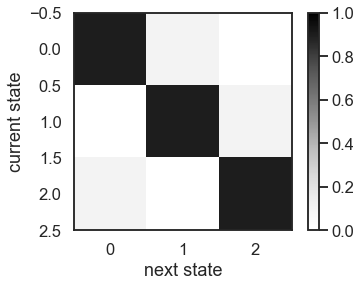

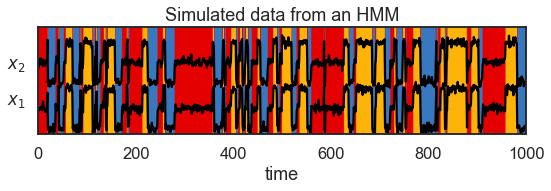

In [18]:
transition_matrix = 0.9 * np.eye(3) \
                    + 0.1 * np.roll(np.eye(3), 1, axis=1)
emission_means = np.arange(6, dtype=float).reshape((3, 2)) - 3

true_hmm = make_gaussian_hmm(
    num_states=3, 
    emission_dim=2,
    transition_matrix=transition_matrix,
    emission_means=emission_means,
    emission_scale_trils=0.25 * np.eye(2))

states, data = true_hmm.sample(jr.PRNGKey(0), 1000)

def plot_transition_matrix(transition_matrix):
    plt.imshow(transition_matrix, vmin=0, vmax=1, cmap="Greys")
    plt.xlabel("next state")
    plt.ylabel("current state")
    plt.colorbar()
    plt.show()


def plot_hmm_data(obs, states):
    lim = 1.01 * abs(obs).max()
    time_bins, obs_dim = obs.shape
    plt.figure(figsize=(8, 3))
    plt.imshow(states[None,:],
            aspect="auto",
            cmap=cmap,
            vmin=0,
            vmax=len(colors)-1,
            extent=(0, time_bins, -lim, (obs_dim)*lim))

    for d in range(obs_dim):
        plt.plot(obs[:,d] + lim * d, '-k')

    plt.xlim(0, time_bins)
    plt.xlabel("time")
    plt.yticks(lim * np.arange(obs_dim), ["$x_{}$".format(d+1) for d in range(obs_dim)])

    plt.title("Simulated data from an HMM")

    plt.tight_layout()

plot_transition_matrix(transition_matrix)
plot_hmm_data(data, states)

## Fit Gaussian HMM using hmm_log_normalizer

100%|██████████| 1000/1000 [00:01<00:00, 820.53it/s]


Text(0, 0.5, 'objective')

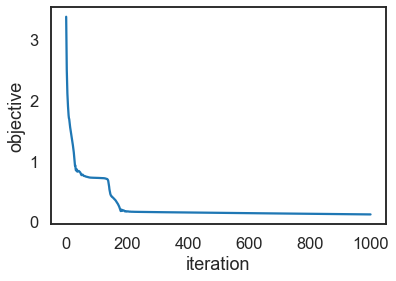

In [19]:
seed = jr.PRNGKey(1)
learning_rate = 0.1

num_states_est = 3
emission_means = 3 * jr.normal(seed, shape=(num_states_est, 2))
hmm = make_gaussian_hmm(num_states_est, 2, 
                        transition_logits=np.zeros((num_states_est, num_states_est)), 
                        emission_means=emission_means)

def objective(hmm):
    lp = hmm_log_normalizer(*hmm.natural_parameters(data))
    return -lp / data.size

opt_init, opt_update, get_params = optimizers.adam(learning_rate)
opt_state = opt_init(hmm)

@jit
def step(step, opt_state):
  value, grads = value_and_grad(objective)(get_params(opt_state))
  opt_state = opt_update(step, grads, opt_state)
  return value, opt_state

vals = []
for i in trange(1000):
    value, opt_state = step(i, opt_state)
    vals.append(value)

plt.plot(vals)
plt.xlabel("iteration")
plt.ylabel("objective")

In [20]:
fitted_hmm = get_params(opt_state)
Z, (Ez0, Ezzp1, Ez) = hmm_expected_states(*fitted_hmm.natural_parameters(data))
perm = find_permutation(states, np.argmax(Ez, axis=-1))

True transition matrix


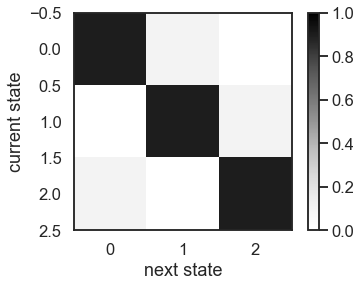

Estimated transition matrix


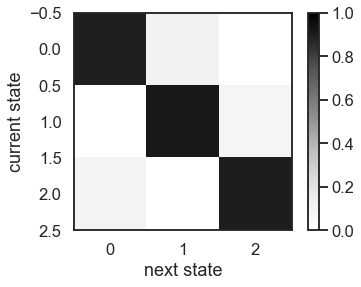

In [21]:
print("True transition matrix")
plot_transition_matrix(true_hmm.transition_matrix)

print("Estimated transition matrix")
plot_transition_matrix(fitted_hmm.transition_matrix[:, perm][perm, :])

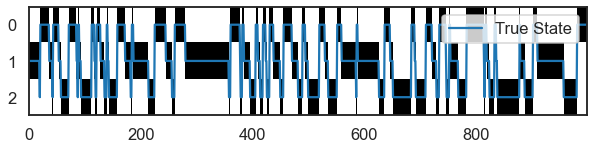

In [22]:
plt.figure(figsize=(10, 2))
plt.imshow(Ez.T[perm, :], aspect="auto", interpolation="none", vmin=0, vmax=1, cmap="Greys")
plt.plot(states, '-', label="True State")
plt.legend()
plt.show()

## Fit HMM using EM

[converged] LP: -363.582:  14%|█▍        | 14/100 [00:01<00:10,  8.24it/s]


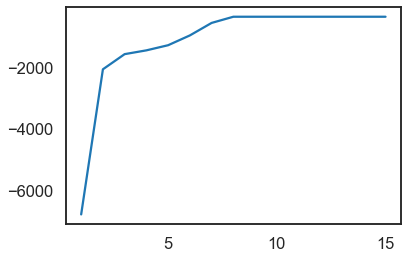

In [23]:
seed = jr.PRNGKey(1)
learning_rate = 0.05

num_states_est = 3
emission_means = 3 * jr.normal(seed, shape=(num_states_est, 2))
hmm = make_gaussian_hmm(num_states_est, 2, 
                        transition_logits=np.zeros((num_states_est, num_states_est)), 
                        emission_means=emission_means)

from ssm.inference.em.hmm import em
log_probs, fitted_hmm, posterior = em(hmm, data)

plt.plot(log_probs)
plt.show()

In [24]:
Z, (Ez0, Ezzp1, Ez) = hmm_expected_states(*fitted_hmm.natural_parameters(data))
perm = find_permutation(states, np.argmax(Ez, axis=-1))

True transition matrix


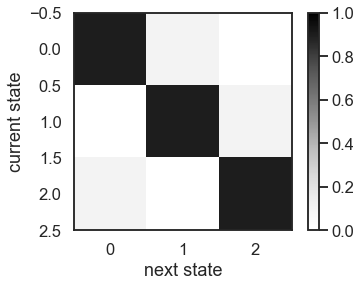

Estimated transition matrix


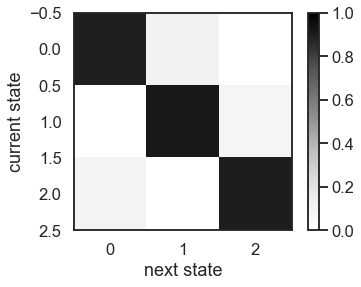

In [25]:
print("True transition matrix")
plot_transition_matrix(true_hmm.transition_matrix)

print("Estimated transition matrix")
plot_transition_matrix(fitted_hmm.transition_matrix[:, perm][perm, :])

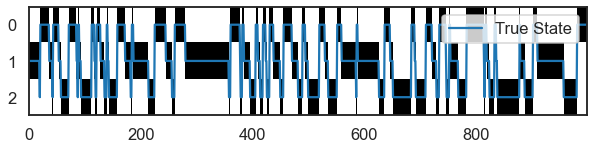

In [26]:
plt.figure(figsize=(10, 2))
plt.imshow(Ez.T[perm, :], aspect="auto", interpolation="none", vmin=0, vmax=1, cmap="Greys")
plt.plot(states, '-', label="True State")
plt.legend()
plt.show()